## Lab 5b: Malkiel Pricing Rules and Interest Rate Risk
The objective of `Lab 5c` is to familiarize students with computing the prices of Treasury Bills, Notes, and Bonds and to compare simulations of the change in the prices of these instruments with the five theorems proposed by Malkiel:

* [Malkiel, B. G. (1962). Expectations, Bond Prices, and the Term Structure of Interest Rates. The Quarterly Journal of Economics, 76(2), 197–218. https://doi.org/10.2307/1880816](https://www.jstor.org/stable/1880816https://www.jstor.org/stable/1880816)

Malkiel proposed five theorems that govern the price of fixed-income debt securities, e.g., Treasury Bills, Notes, and Bonds, as a function of the duration and yield values. In this lab, let's simulate Theorems 1, 2, and 4:

- __T1__: Bond prices move inversely to bond yields.
- __T2__: For a given change in yield from the nominal yield, changes in bond prices are greater the longer the term to maturity. 
- __T4__: Price movements resulting from equal absolute increases and decreases in yield are asymmetric; i.e., decreasing yields raises bond prices more than the same increase in yields lowers prices.

### Tasks
1. __Duration__ (10 minutes): Break into teams and familiarize yourself with the lab structure, particularly the `packages`, `types,` and `functions` used in the lab. As part of this task, include the the required external packages used in the computation (this could take some time for compilation; do this first before anything else)
1. __Duration__ (5 minutes): Load and familiarize yourself with the historical dataset used in this lab. Do you understand the various fields in the datasets?
1. __Duration__ (15 minutes): Test Theorem 1 using historical data from the Treasury bill dataset.
    - Pick a random bill and compute the price. Check if the calculated price is consistent with the auction price using the `@assert isapprox(...)` approach
    - Using a `for` loop, compute the price of the Treasury bill for different values of the interest rate by perturbing the actual rate $\bar{r}$ as $r_{i} = \beta_{i}\cdot{\bar{r}}$
    - Plot $\beta$ versus the computed price. Do the results support Theorem 1?
1. __Duration__ (15 minutes): Test Theorem 2 using historical data from the Treasury notes and bonds dataset.
    - Pick random short and long-duration instruments and compute their prices. Check if the calculated prices are consistent with the auction price using the `@assert isapprox(...)` approach
    - Using a `for` loop, compute the prices of the short and long-duration instruments for different values of the interest rate by perturbing the actual rate $\bar{r}$ as $r_{i} = \beta_{i}\cdot{\bar{r}}$, where $0.8\leq\beta_{i}\leq{1.2}$.
    - Plot $\beta$ versus the computed prices for the short and long-duration instruments. Do the results support Theorem 2?
1. __Duration__ (5 minutes): Do the simulation results from the Theorem 1 test using Treasury bills and the short and long-duration notes (bonds) simulations from the Theorem 2 test support Theorem 4?

### Setup
We load the [VLQuantitativeFinancePackage.jl](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl) package, and several other external [Julia](https://julialang.org/downloads/https://julialang.org/downloads/) packages, as well as some helper code, by calling the [include(...)](https://docs.julialang.org/en/v1/manual/code-loading/https://docs.julialang.org/en/v1/manual/code-loading/) command on the file `Include.jl`:

In [28]:
using Pkg
Pkg.add(path="https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git")

    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
   Resolving package versions...
    Updating `~/Desktop/julia_work/CHEME-5660-Labs-F23/Project.toml`
  [4119e0bf] ~ VLQuantitativeFinancePackage v1.0.0-DEV `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl#main` ⇒ v1.0.0-DEV `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git#main`
    Updating `~/Desktop/julia_work/CHEME-5660-Labs-F23/Manifest.toml`
  [4119e0bf] ~ VLQuantitativeFinancePackage v1.0.0-DEV `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl#main` ⇒ v1.0.0-DEV `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git#main`


In [2]:
include("Include.jl");

  Activating project at `~/Desktop/julia_work/CHEME-5660-Labs-F23`
  No Changes to `~/Desktop/julia_work/CHEME-5660-Labs-F23/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-5660-Labs-F23/Manifest.toml`
    Updating registry at `~/.julia/registries/General.toml`
    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl`
  No Changes to `~/Desktop/julia_work/CHEME-5660-Labs-F23/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-5660-Labs-F23/Manifest.toml`


#### Packages
`Include.jl` loads several external packages that we will use for our excercise:
* [DataFrames.jl](https://dataframes.juliadata.org/stable/) provides a set of tools for working with tabular data in [Julia](https://julialang.org). Its design and functionality are similar to those of [Pandas (in Python)](https://pandas.pydata.org) and [data.frame, data.table and dplyr (in R)](https://dplyr.tidyverse.org), making it a great general purpose data science tool.
* [Plots.jl](https://docs.juliaplots.org/stable/) is a plotting library in [Julia](https://julialang.org). [Plots.jl](https://docs.juliaplots.org/stable/) exports the `plot(...)` function which we use to visualize data.
* [VLQuantitativeFinancePackage.jl](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl) holds the codes and types for most of the computation used in the lab.

#### Types
`Include.jl` loads some [problem-specific types](https://docs.julialang.org/en/v1/manual/functions/) that will be helpful for the analysis of T-bill, T-note and T-bond pricing. 

`MyUSTreasuryZeroCouponBondModel` is a [mutable type](https://docs.julialang.org/en/v1/manual/types/#Mutable-Composite-Types) holding the par value $V_{P}$, the duration $T$ and the interest rate $\bar{r}$ for a zero-coupon treasury bill. You construct a `MyUSTreasuryZeroCouponBondModel` instance using the `build(...)` method described below. This type contains the fields:

* The `par::Float64` field holds the par value of the bill, note or bond
* The `rate::Union{Nothing, Float64}` field holds the annual interest rate (yield at auction) of the bill
* The `T::Union{Nothing,Float64}` field holds the duration in years, measured as a 365 day or a 52 week year
* The `price::Union{Nothing, Float64}` field holds the price of the bill, note or bond
* The `n::Int` field holds the number of compounding periods per year (typically 2)
* The `cashflow::Union{Nothing, Dict{Int,Float64}}` field holds the discounted cashflow per period
* The `discount::Union{Nothing, Dict{Int,Float64}}` field holds the discount factors for each period


The `MyUSTreasuryCouponSecurityModel` is [mutable type](https://docs.julialang.org/en/v1/manual/types/#Mutable-Composite-Types) that holds important information such as the par value $V_{P}$, duration $T$, market interest rate $\bar{r}$, coupon rate $c$, and the number of coupon payments per year $\lambda$ for treasury notes and bonds. To create a `MyUSTreasuryCouponSecurityModel` instance, you can use the `build(...)` method explained below. This type contains the fields:

* The `par::Float64` field holds the par value of the bill, note or bond
* The `rate::Union{Nothing, Float64}` field holds the annual interest rate (yield at auction) of the note or bond
* The `coupon::Union{Nothing, Float64}` field holds the annual coupon rate of the note or bond
* The `T::Union{Nothing,Float64}` field holds the duration in years, measured as a 365 day or a 52 week year
* The `price::Union{Nothing, Float64}` field holds the price of the bill, note or bond
* The `λ::Int` field holds the number of compounding periods per year (typically 2)
* The `cashflow::Union{Nothing, Dict{Int,Float64}}` field holds the discounted cashflow per period
* The `discount::Union{Nothing, Dict{Int,Float64}}` field holds the discount factors for each period

`DiscreteCompoundingModel` and `ContinuousCompoundingModel` are [immutable types](https://docs.julialang.org/en/v1/manual/types/#Composite-Types) that let our code know which compounding/discounting model we wish to use.

#### Functions
`Include.jl` loads the following [Julia functions](https://docs.julialang.org/en/v1/manual/functions/) into the notebook:

`build(model::Type{MyUSTreasuryCouponSecurityModel}, data::NamedTuple) -> MyUSTreasuryCouponSecurityModel` 
> This function takes information in the `data` [NamedTuple](https://docs.julialang.org/en/v1/base/base/#Core.NamedTuple) argument (the par value, etc.) and returns an instance of the `MyUSTreasuryCouponSecurityModel` [mutable type](https://docs.julialang.org/en/v1/manual/types/#Mutable-Composite-Types).

`build(model::Type{MyUSTreasuryZeroCouponBondModel}, data::NamedTuple) -> MyUSTreasuryZeroCouponBondModel` 
> This function takes information in the `data` [NamedTuple](https://docs.julialang.org/en/v1/base/base/#Core.NamedTuple) argument (the par value, etc.) and returns an instance of the `MyUSTreasuryZeroCouponBondModel` [mutable type](https://docs.julialang.org/en/v1/manual/types/#Mutable-Composite-Types).

The `MyTreasuryBillDataSet()` and `MyTreasuryNotesAndBondsDataSet()` functions load the historical datasets used in the lab

#### Constants
We'll assume discrete compounding, and setup a pertrurbation array $\beta$ with `number_of_samples` elements:

In [3]:
discount_model = DiscreteCompoundingModel();
number_of_samples = 7;
β₁ = 0.8;
β₂ = 1.2;
β = range(β₁, stop = β₂, length = number_of_samples) |> collect;

#### Load Historical Treasury Auction Data
We'll explore `T-Bill`, `T-note` and `T-bond` prices from United States Treasury auctions in `2022` and `2023` downloaded using the [Auction query functionality of TreasuryDirect.gov](https://www.treasurydirect.gov/auctions/auction-query/). We load the `CSV` dataset using the `MyTreasuryBillDataSet()` and `MyTreasuryNotesAndBondsDataSet()` functions, which return the auction datasets as `DataFrame` instances, see [DataFrames.jl](https://github.com/JuliaData/DataFrames.jl) for a background on working with `DataFrames`:

In [4]:
bill_dataset = MyTreasuryBillDataSet();
notes_bonds_dataset = MyTreasuryNotesAndBondsDataSet();

In [27]:
notes_bonds_dataset

Row,CUSIP,Security Type,Security Term,Auction Date,Issue Date,Maturity Date,Price,High Yield,Interest Rate
,String15,String7,String7,String15,String15,String15,Float64,Float64,Float64
1,91282CHW4,Note,7-Year,08/29/2023,08/31/2023,08/31/2030,99.4773,0.04212,0.04125
2,91282CHV6,Note,2-Year,08/28/2023,08/31/2023,08/31/2025,99.9549,0.05024,0.05
3,91282CHX2,Note,5-Year,08/28/2023,08/31/2023,08/31/2028,99.8889,0.044,0.04375
4,912810TU2,Bond,20-Year,08/23/2023,08/31/2023,08/15/2043,98.3742,0.04499,0.04375
5,912810TT5,Bond,30-Year,08/10/2023,08/15/2023,08/15/2053,98.9127,0.04189,0.04125
6,91282CHT1,Note,10-Year,08/09/2023,08/15/2023,08/15/2033,98.9862,0.03999,0.03875
7,91282CHU8,Note,3-Year,08/08/2023,08/15/2023,08/15/2026,99.936,0.04398,0.04375
8,91282CHR5,Note,7-Year,07/27/2023,07/31/2023,07/31/2030,99.475,0.04087,0.04
9,91282CHQ7,Note,5-Year,07/25/2023,07/31/2023,07/31/2028,99.7988,0.0417,0.04125


## Test Theorem 1 using Zero-Coupon Treasury Bills

First, let's build a model of the zero-coupon Treasury bill, which is a `MyUSTreasuryZeroCouponBondModel` instance, and check that the predicted price is consistent with the observed auction price. Then, we will vary the parameters of the zero-coupon Treasury bill to test whether `Theorem 1` holds. How many Bills do we have in the `bill_dataset`:

In [6]:
number_of_bills = nrow(bill_dataset);
println("There are $(number_of_bills) T-bills in the bill dataset")

There are 96 T-bills in the bill dataset


Select a random bill from the dataset, an index from `1...number_of_bills`:

In [7]:
random_bill_index = 10;

To create an instance of the `MyUSTreasuryZeroCouponBondModel` model, we will use the `build(...)` method and assume a par value of `100 USD` with two compounding periods per year. These values will be passed as arguments to the `build(...)` method in the `par` and `n` parameters. Update the rest of the  parameters on the `zero_coupon_model` instance from the `bill_dataset`. The resulting zero-coupon model will be stored in the `model` variable. 

In [8]:
# fill me in
zero_coupon_model = nothing;

In [9]:
# zero_coupon_model = build(MyUSTreasuryZeroCouponBondModel, (
#     par = 100.0, n = 2, 
#     T = bill_dataset[random_bill_index, Symbol("Security Term")] |> String |> securityterm,
#     rate =  bill_dataset[random_bill_index, Symbol("Investment Rate")]
# )) |> discount_model;

#### Check: Is the computed price _similar_ to the auction price $V_{B}$?
The [isapprox function](https://docs.julialang.org/en/v1/base/math/#Base.isapprox) allows us to check the equality of numerical values up to some `rtol` value. If the values are within `rtol` of each other, this function returns `true`; otherwise, it returns `false`. When combined with the [@assert macro](https://docs.julialang.org/en/v1/base/base/#Base.@assert), the [isapprox function](https://docs.julialang.org/en/v1/base/math/#Base.isapprox)[isapprox function](https://docs.julialang.org/en/v1/base/math/#Base.isapprox) can be used to check a boolean condition, if the condition is `false` the assertion fails and an error is thrown:

In [10]:
VB = bill_dataset[random_bill_index, :Price];
computed_price = zero_coupon_model.price
@assert isapprox(VB, computed_price; rtol=1e-3)

LoadError: type Nothing has no field price

### Compute the change of the `T-bill` price as a function of the yield
Compute the price of the selected T-bill using different values for the market investment rate, i.e., the effective interest rate, and store the results in the `theorem_1_simulation_array` variable. Iterate through each value of the $\beta$ array using a `for` loop. For iteration $i$ of the loop:

* Get a value for the perturbation $\beta_{i}$ from the $\beta$-array, and compute the new effective interest rate $\bar{r}_{i} = \beta_{i}\cdot{\bar{r}}$.
* Update the `zero_coupon_model` instance with the new rate (set the `rate` field), and compute the new price
* Store the $\beta_{i}$ value in column 1, and the percentage difference in price in column 2 of the `theorem_1_simulation_array`

In [11]:
theorem_1_simulation_array = Array{Float64,2}(undef, number_of_samples, 2);
for i ∈ eachindex(β)
    
    # Fill me in here ....
    
end
theorem_1_simulation_array;

In [12]:
# theorem_1_simulation_array = Array{Float64,2}(undef, number_of_samples, 2);
# for i ∈ eachindex(β)
    
#     β_value = β[i];
#     r̄ = bill_dataset[random_bill_index, Symbol("Investment Rate")];
#     r̄_value = β_value*bill_dataset[random_bill_index, Symbol("Investment Rate")];
#     zero_coupon_model.rate = r̄_value;
#     new_price = zero_coupon_model |> discount_model |> x-> x.price
    
#     theorem_1_simulation_array[i,1] = β_value
#     theorem_1_simulation_array[i,2] = ((new_price - computed_price)/(computed_price))*100
# end
# theorem_1_simulation_array;

### Visualize the percentage change in T-Bill price

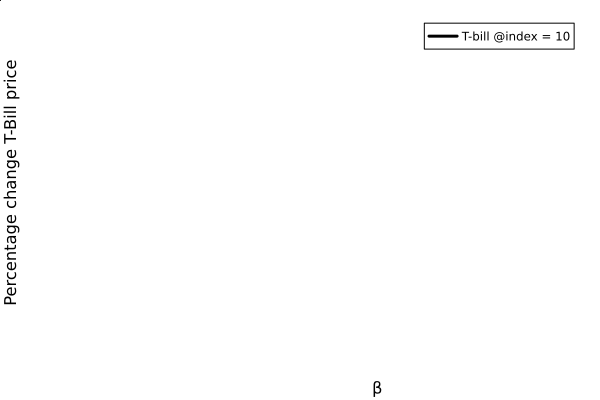

In [13]:
if (isempty(theorem_1_simulation_array) == false)
    plot(theorem_1_simulation_array[:,1], theorem_1_simulation_array[:,2], lw=3, c=:black, xlabel="β", 
        ylabel="Percentage change T-Bill price", label="T-bill @index = $(random_bill_index)")
end

## Test Theorem 2 using Short versus Long Duration Treasury Notes or Bonds
Theorem 2 suggests that the greater the term to maturity, the more significant the change in bond prices for a given change in yield from the nominal yield. To test this, we will create models for two instruments - notes/bonds $i$ and $j$ from the `notes_bonds_dataset`, with a significant difference in duration, such as `5 years` versus `30 years`, and then simulate how the price of these instruments changes as well vary the yield by the same percentage. Assume a $V_{P} = 100$ USD for both instruments and semiannual compounding.

In [14]:
notes_bonds_dataset

Row,CUSIP,Security Type,Security Term,Auction Date,Issue Date,Maturity Date,Price,High Yield,Interest Rate
,String15,String7,String7,String15,String15,String15,Float64,Float64,Float64
1,91282CHW4,Note,7-Year,08/29/2023,08/31/2023,08/31/2030,99.4773,0.04212,0.04125
2,91282CHV6,Note,2-Year,08/28/2023,08/31/2023,08/31/2025,99.9549,0.05024,0.05
3,91282CHX2,Note,5-Year,08/28/2023,08/31/2023,08/31/2028,99.8889,0.044,0.04375
4,912810TU2,Bond,20-Year,08/23/2023,08/31/2023,08/15/2043,98.3742,0.04499,0.04375
5,912810TT5,Bond,30-Year,08/10/2023,08/15/2023,08/15/2053,98.9127,0.04189,0.04125
6,91282CHT1,Note,10-Year,08/09/2023,08/15/2023,08/15/2033,98.9862,0.03999,0.03875
7,91282CHU8,Note,3-Year,08/08/2023,08/15/2023,08/15/2026,99.936,0.04398,0.04375
8,91282CHR5,Note,7-Year,07/27/2023,07/31/2023,07/31/2030,99.475,0.04087,0.04
9,91282CHQ7,Note,5-Year,07/25/2023,07/31/2023,07/31/2028,99.7988,0.0417,0.04125


### Pick the index of the `short` and `long` duration instruments 

In [15]:
short_duration_index = 0; 
long_duration_index = 0;

### Compute the `base` short-duration price
Create an instance of the `MyUSTreasuryCouponSecurityModel` using the `build(...)` method using the parameters associated with the `short duration` note or bond, and call this model `short_duration_model`. Compute the price of the `short_duration_model` using the `model |> discount_model` short-cut syntax:

In [16]:
short_duration_model = nothing;

In [17]:
# short_duration_model = build(MyUSTreasuryCouponSecurityModel, (
#     par = 100, λ = 2, 
#     T = notes_bonds_dataset[short_duration_index, Symbol("Security Term")] |> String |> securityterm,
#     rate = notes_bonds_dataset[short_duration_index, Symbol("High Yield")],
#     coupon = notes_bonds_dataset[short_duration_index, Symbol("Interest Rate")],
# )) |> discount_model;

#### Check: Is the short duration computed price _similar_ to the auction price $V_{B}$? 
Use the [isapprox function](https://docs.julialang.org/en/v1/base/math/#Base.isapprox) in combination with the [@assert macro](https://docs.julialang.org/en/v1/base/base/#Base.@assert) to check verify the `computed_short_duration_price` is consistent with the price observed at auction, stored in the `VB_short_duration` variable:

In [18]:
VB_short_duration = nothing
computed_short_duration_price = nothing
@assert isapprox(VB_short_duration, computed_short_duration_price; rtol=1e-4)

LoadError: MethodError: no method matching isapprox(::Nothing, ::Nothing; rtol::Float64)

[0mClosest candidates are:
[0m  isapprox(::Any, ::Any, [91m::MathOptInterface.Test.Config{T}[39m) where T[91m got unsupported keyword argument "rtol"[39m
[0m[90m   @[39m [35mMathOptInterface[39m [90m~/.julia/packages/MathOptInterface/LQvlf/src/Test/[39m[90m[4mTest.jl:307[24m[39m
[0m  isapprox([91m::Missing[39m, ::Any; kwargs...)
[0m[90m   @[39m [90mBase[39m [90m[4mmissing.jl:90[24m[39m
[0m  isapprox(::Any; kwargs...)
[0m[90m   @[39m [90mBase[39m [90m[4mfloatfuncs.jl:320[24m[39m
[0m  ...


In [19]:
# VB_short_duration = notes_bonds_dataset[short_duration_index, :Price];
# computed_short_duration_price = short_duration_model.price;
# @assert isapprox(VB_short_duration, computed_short_duration_price; rtol=1e-4)

### Compute the `base` long duration price
Create an instance of the `MyUSTreasuryCouponSecurityModel` using the `build(...)` method using the parameters associated with the `long duration` note or bond, and call this model `long_duration_model`. Compute the price of the `long_duration_model` using the `model |> discount_model` short-cut syntax:

In [20]:
long_duration_model = nothing;

In [21]:
# long_duration_model = build(MyUSTreasuryCouponSecurityModel, (
#     par = 100, λ = 2, 
#     T = notes_bonds_dataset[long_duration_index, Symbol("Security Term")] |> String |> securityterm,
#     rate = notes_bonds_dataset[long_duration_index, Symbol("High Yield")],
#     coupon = notes_bonds_dataset[long_duration_index, Symbol("Interest Rate")],
# )) |> discount_model;

#### Check: Is the long duration computed price _similar_ to the auction price $V_{B}$? 
Use the [isapprox function](https://docs.julialang.org/en/v1/base/math/#Base.isapprox) in combination with the [@assert macro](https://docs.julialang.org/en/v1/base/base/#Base.@assert) to check verify the `computed_long_duration_price` is consistent with the price observed at auction, stored in the `VB_long_duration` variable:

In [22]:
VB_long_duration = nothing
computed_long_duration_price = nothing
@assert isapprox(VB_long_duration, computed_long_duration_price; rtol=1e-4)

LoadError: MethodError: no method matching isapprox(::Nothing, ::Nothing; rtol::Float64)

[0mClosest candidates are:
[0m  isapprox(::Any, ::Any, [91m::MathOptInterface.Test.Config{T}[39m) where T[91m got unsupported keyword argument "rtol"[39m
[0m[90m   @[39m [35mMathOptInterface[39m [90m~/.julia/packages/MathOptInterface/LQvlf/src/Test/[39m[90m[4mTest.jl:307[24m[39m
[0m  isapprox([91m::Missing[39m, ::Any; kwargs...)
[0m[90m   @[39m [90mBase[39m [90m[4mmissing.jl:90[24m[39m
[0m  isapprox(::Any; kwargs...)
[0m[90m   @[39m [90mBase[39m [90m[4mfloatfuncs.jl:320[24m[39m
[0m  ...


### Compute the change of the short and long-duration prices as a function of the yield 
Compute the price of the short and long-duration notes or bonds using different values for the yield (stored in the `rate` field), and store the results in the `theorem_2_simulation_array` variable. Iterate through each value of the $\beta$ array using a `for` loop. For iteration $i$ of the loop:

* Get a value for the perturbation $\beta_{i}$ from the $\beta$-array, and compute the new effective rate value for each model $\bar{r}_{i} = \beta_{i}\cdot{\bar{r}}$.
* Update the `short_duration_model` and the `long_duration_model` models instances with the new rates (set the `rate` field), and compute the new prices
* Store the $\beta_{i}$ value in column 1, and the percentage difference in price for each instrument in column 2 (short) and column 3 (long) of the `theorem_2_simulation_array`

In [23]:
theorem_2_simulation_array = Array{Float64,2}(undef, number_of_samples, 3);
for i ∈ eachindex(β)
    
    # Fill me in here ....
    
end
theorem_2_simulation_array;

In [24]:
# theorem_2_simulation_array = Array{Float64,2}(undef, number_of_samples, 3);
# for i ∈ eachindex(β)
    
#     β_value = β[i];
#     short_duration_model.rate = β_value*(notes_bonds_dataset[short_duration_index, Symbol("High Yield")]);
#     long_duration_model.rate = β_value*(notes_bonds_dataset[long_duration_index, Symbol("High Yield")]);
    
#     new_short_duration_price = short_duration_model |> discount_model |> x-> x.price
#     new_long_duration_price = long_duration_model |> discount_model |> x-> x.price
    
#     theorem_2_simulation_array[i,1] = β_value
#     theorem_2_simulation_array[i,2] = ((new_short_duration_price - computed_short_duration_price)/computed_short_duration_price)*100
#     theorem_2_simulation_array[i,3] = ((new_long_duration_price - computed_long_duration_price)/computed_long_duration_price)*100
# end

### Visualize

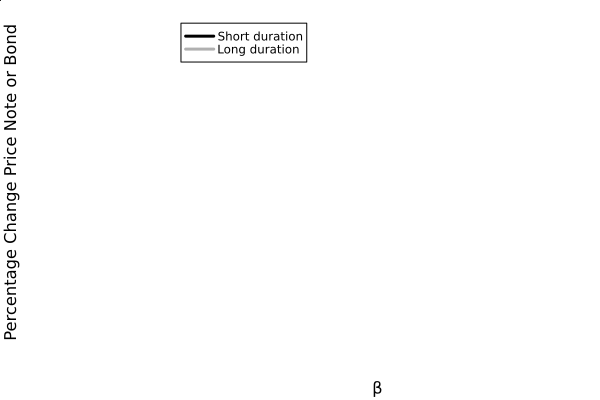

In [25]:
plot(theorem_2_simulation_array[:,1], theorem_2_simulation_array[:,2], label="Short duration", lw=3, c=:black, 
        xlabel="β", ylabel="Percentage Change Price Note or Bond")
plot!(theorem_2_simulation_array[:,1], theorem_2_simulation_array[:,3], label="Long duration", lw=3, c=:gray69, 
        xlabel="β", ylabel="Percentage Change Price Note or Bond")

## Does the Theorem 2 test support Theorem 4?
Look at the values contained in `theorem_2_simulation_array`. Does this data support the asymmetric change in price supposition?

In [26]:
# fill me in